In [38]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Activation, Conv2D, MaxPooling2D
from keras import optimizers, callbacks 

from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization,Add,Dropout, Activation, Flatten
from keras.models import Model, load_model

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils, plot_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from keras.preprocessing.image import ImageDataGenerator

import collections


In [75]:
sample_sub = pd.read_csv('data/sample_submission.csv')

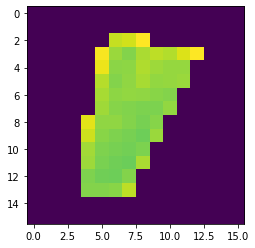

[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.  977.  998. 1069.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0. 1062.  913.  875.  935.  966.  950. 1018.
  1073.    0.    0.    0.]
 [   0.    0.    0.    0.    0. 1040.  887.  889.  947.  914.  905.  902.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  952.  873.  893.  933.  900.  904.  913.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  933.  892.  897.  894.  883.  876.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  918.  878.  870.  863.  862.  899.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0. 1028.  896.  894.  874.  854.  880.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.  991.  881.  866.  851.  838.  913.    0.    0.
     0.    0.    

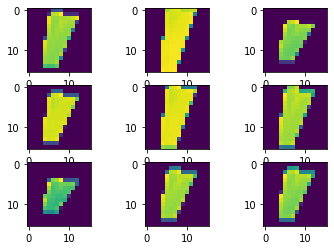

In [138]:

# https://www.pyimagesearch.com/2017/12/11/image-classification-with-keras-and-deep-learning/
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

img = np.load('croped_images/2017-01-01/train16/class8/index0.npy')  # this is a npy array
img = np.transpose(img, (2,1,0))
# print(img.shape)


## From here https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

samples = np.expand_dims(img, 0)
# print(samples.shape)

# datagen = ImageDataGenerator(rotation_range=180, width_shift_range=0.05,
#     height_shift_range=0.05, shear_range=0.2, zoom_range=0.6,
#     horizontal_flip=True, fill_mode="nearest")
datagen = ImageDataGenerator(zoom_range=0.6)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
plt.imshow(img[1])
plt.show()
print(img[1])
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0]
    # plot raw pixel data
    print(image.shape)
    plt.imshow(image[1])
    print(image[1])
# show the figure
plt.show()

In [95]:
## Prepare the data
X_train = []
y_train = []

X_test = []

parent_path = 'croped_images/2017-01-01/train16/'
for folder in os.listdir(parent_path):
    if os.path.isdir(os.path.join(parent_path, folder)):
        class_name = folder[-1]
        for file in (os.listdir(os.path.join(parent_path, folder))):
            x = np.load(os.path.join(parent_path, folder, file))
            X_train.append(x)
            y_train.append(class_name)
            
parent_path = 'croped_images/2017-01-01/test16/'
for file in os.listdir(parent_path):
    x = np.load(os.path.join(parent_path, file))
    X_test.append(x)

class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights = list(class_weights)
print(class_weights)
            
X_test = np.array(X_test)
X_train = np.array(X_train)
y_train_df = pd.DataFrame(y_train)
y_train = np.array(pd.get_dummies(y_train_df))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_train)

[1.9514866979655712, 39.58730158730159, 2.9169590643274854, 0.5169983416252073, 0.9791912053396152, 1.8980213089802132, 1.0378693300041615, 0.29448577163773765, 3.5988455988455987]
(2494, 16, 16, 5)
(1074, 16, 16, 5)
(2494, 9)
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [ ]:
# construct the image generator for data augmentation

# https://stats.stackexchange.com/questions/175504/how-to-do-data-augmentation-and-train-validate-split
# Data augmentation must be done only on training data and not the validation data since we want to simulate the 
# performance of the model on real world data
datagen = ImageDataGenerator(rotation_range=180, width_shift_range=0.05,
    height_shift_range=0.05, shear_range=0.2, zoom_range=0.6,
    horizontal_flip=True, fill_mode="nearest")

datagen.fit(X_train)

In [87]:
def create_cnn_model(inp_shape):
    
    #inp_shape = (16, 16, 5)
    print(inp_shape)
    inp = Input(shape= inp_shape)
    
    x = Conv2D(32, (3, 3))(inp)
    x = LeakyReLU(alpha=0.1)(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(32, (3, 3))(x)
    x = LeakyReLU(alpha=0.1)(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3))(x)
    x = LeakyReLU(alpha=0.1)(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # the model so far outputs 3D feature maps (height, width, features)
    
    # this converts our 3D feature maps to 1D feature vectors
#     print(x)
    x = Flatten()(x)
    
    x = Dense(16)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0)(x)
    x = Dropout(0.5)(x) 
    
    out = Dense(9, activation="softmax")(x)
    
    model = Model(inputs=inp, outputs=[out])
    return model

In [88]:
model = create_cnn_model(X_train[1].shape)
print(model.summary())

(16, 16, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 16, 16, 5)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 14, 14, 32)        1472      
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 10, 10, 64)        0        

In [89]:
def compile_model():
    model = create_cnn_model(X_train[1].shape)
    adam = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [90]:
def plot_history(history, label):
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.plot(history.history["acc"], label="train_acc")
    plt.plot(history.history["val_acc"], label="val_acc")
    plt.title('Training Loss and Accuracy  for %s' % label)
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()

In [97]:
epoch_n = 1000
batch_size = 64
verbose = 1
file_name = 'cnn_3CN1D_noMAxPooling_bs'+str(batch_size)
model_name_wrt = 'models/cnn/' + file_name+'.hdf5' 

# Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=100,verbose=1, mode='auto', 
                             restore_best_weights=True)
# Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=30, min_lr=1e-6, mode='auto', verbose=1)
# Save the best value of the model for future use
sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)

cnn_model = compile_model()
# history = cnn_model.fit(X_train, y_train, 
#                        validation_split=0.1, 
#                        class_weight=class_weights,
#                        callbacks=[es, rlr, sv_mod], 
#                        epochs=epoch_n, 
#                        batch_size=batch_size, 
#                        verbose=verbose)
history = cnn_model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                  
                    steps_per_epoch=len(X_train) / batch_size, epochs=epoch_n)

(16, 16, 5)


/anaconda/envs/py36/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2494, 16, 16, 5) (5 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/1000
39/38 [==============================] - 4s 90ms/step - loss: 2.3761 - acc: 0.2074
Epoch 2/1000
39/38 [==============================] - 1s 38ms/step - loss: 2.0108 - acc: 0.3709
Epoch 3/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.8549 - acc: 0.4062
Epoch 4/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.7676 - acc: 0.4226
Epoch 5/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.7432 - acc: 0.4459
Epoch 6/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.7003 - acc: 0.4711
Epoch 7/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.6923 - acc: 0.4507
Epoch 8/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.6803 - acc: 0.4567
Epoch 9/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.6603 - acc: 0.4643
Epoch 10/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.6344 - acc: 0.4707
Epoch 11/1000
39/38 [==================

39/38 [==============================] - 2s 39ms/step - loss: 1.4498 - acc: 0.5136
Epoch 169/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.4630 - acc: 0.5241
Epoch 170/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.4657 - acc: 0.5276
Epoch 171/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.4531 - acc: 0.5244
Epoch 172/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.4716 - acc: 0.5240
Epoch 173/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.4667 - acc: 0.5232
Epoch 174/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.4409 - acc: 0.5305
Epoch 175/1000
39/38 [==============================] - 2s 39ms/step - loss: 1.4516 - acc: 0.5177
Epoch 176/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.4682 - acc: 0.5241
Epoch 177/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.4473 - acc: 0.5213
Epoch 178/1000
39/38 [=============

39/38 [==============================] - 1s 38ms/step - loss: 1.4199 - acc: 0.5302
Epoch 335/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.4001 - acc: 0.5368
Epoch 336/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.4039 - acc: 0.5413
Epoch 337/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.4095 - acc: 0.5437
Epoch 338/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.4061 - acc: 0.5408
Epoch 339/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.3988 - acc: 0.5380
Epoch 340/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.4073 - acc: 0.5325
Epoch 341/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.4026 - acc: 0.5377
Epoch 342/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.3962 - acc: 0.5341
Epoch 343/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.4198 - acc: 0.5357
Epoch 344/1000
39/38 [=============

39/38 [==============================] - 1s 37ms/step - loss: 1.3852 - acc: 0.5469
Epoch 501/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.3937 - acc: 0.5473
Epoch 502/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.4048 - acc: 0.5437
Epoch 503/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.4042 - acc: 0.5485
Epoch 504/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.3739 - acc: 0.5457
Epoch 505/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.3724 - acc: 0.5493
Epoch 506/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.3982 - acc: 0.5433
Epoch 507/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.3967 - acc: 0.5384
Epoch 508/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.3943 - acc: 0.5361
Epoch 509/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.3893 - acc: 0.5449
Epoch 510/1000
39/38 [=============

39/38 [==============================] - 1s 37ms/step - loss: 1.3556 - acc: 0.5513
Epoch 667/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.3626 - acc: 0.5462
Epoch 668/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.3873 - acc: 0.5349
Epoch 669/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.3600 - acc: 0.5505
Epoch 670/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.3680 - acc: 0.5377
Epoch 671/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.3686 - acc: 0.5473
Epoch 672/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.3820 - acc: 0.5306
Epoch 673/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.3701 - acc: 0.5456
Epoch 674/1000
39/38 [==============================] - 1s 37ms/step - loss: 1.3737 - acc: 0.5440
Epoch 675/1000
39/38 [==============================] - 1s 38ms/step - loss: 1.3792 - acc: 0.5465
Epoch 676/1000
39/38 [=============

KeyboardInterrupt: 

In [ ]:
plot_history(history, 'cnn')

best_model = load_model(model_name_wrt)
test_predict=best_model.predict(X_test)

predicted_classes = test_predict.argmax(1)+1
counter=collections.Counter(predicted_classes)
print(counter)
sns.countplot(predicted_classes, palette='Set3')

prob = pd.DataFrame(test_predict)
# prob = pd.DataFrame(get_prediction_from_np_array(test_predict))
prob.columns = ['crop_id_1', 'crop_id_2', 'crop_id_3', 'crop_id_4', 'crop_id_5', 'crop_id_6', 'crop_id_7','crop_id_8', 'crop_id_9']
print(prob.shape)

submission = pd.DataFrame()
submission['field_id'] = sample_sub['field_id']
submission = submission.join(prob)
submission.head(10)

submission.to_csv('predictions/reduced_tabular/'+file_name+'.csv', index=False)